In [1384]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

def convert_prob_to_label(prob, cutoff = 0.5):
    label = []
    for i in range(len(prob)):
        if prob[i] > cutoff:
            label.append(1)
        else:
            label.append(0)
    return label

# Logistic Regression: StatsModels and Details of Regression

We can do some more logitic regression to make classification predictions, there's some things that we do to try to drive accuracy up, and some other work we can do to interpret the accuracy better. 

In [1385]:
#Read diabetes data
df = pd.read_csv("data/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Baseline Accuracy

Before we get going, we'll touch on a simple concept - the baseline accuracy. For example, in post WW2 Germany the ratio of males to females was approximately .6 (3:5) for people in their 20s - or approximately 5/8 or 62.5% of people were females. 

If we were to build some model to predict if a twenty-soemthing was a male or female, this should be the worst we can do. A 'default' model of always guessing female will be 62.5% accurate, so if we can't beat that, we suck and are useless. 

In [1386]:
#baseline for diabetes
1 - df["Outcome"].mean()

0.6510416666666667

So... a model guessing NO at all times would be ~65% accurate here, so that's our worst case scenario. 

In [1387]:
X1 = np.array(df.drop("Outcome", axis=1))
y1 = np.array(df["Outcome"])

#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

#Create a logistic regression model
check_model = LogisticRegression(max_iter=1000)

check_model.fit(X_train, y_train)

#Predict the test set
y_pred = check_model.predict(X_test)

#Accuracy
print("Train set accuracy: ", accuracy_score(y_train, check_model.predict(X_train)))
print("Test set accuracy: ", accuracy_score(y_test, y_pred))


Train set accuracy:  0.7703583061889251
Test set accuracy:  0.7467532467532467


## Classification Accuracy Metrics

Now, the accuracy is ok, but we have a noticable imbalance between false negatives and false positives (exact split we bounce around due to randomness - when I built this the frist run was pretty large, other runs were smaller). We previously looked briefly at all the different accuracy metrics that can be generated from the confusion matrix. In real use, you need to combine some domain knowledge with these results to choose the measures that make sense for what you're doing. 

<b>Note:</b> this one shows normalized values, aka percentages. 

![Confusion Matrix](images/conf_mat_small.png "Confusion Matrix")

### Precision

Precision is the ratio of the True Positives to all of the True Positives + False Positives. 

Precision is most useful as a metric when we want to avoid false positives - think about if you are predicting terrorists, you don't want to Guantanamo aunt Betty on the way home from her bake sale. 

### Recall / Sensitivity

Recall is the ratio of the True Positives to the True Positives + False Negatives. 

Recall is most useful as a metric when we really want to identify all of the positives - think about if you are predicting terrorists, you want to get them all. 

![Precision - Recall](images/prec_rec.png "Precision - Recall")

### F1 Score

There is one score that is pretty common that may be helpful  - the F1 score. The F1 score seeks to balance PRECISION (avoid false positives) and RECALL (target true positives, at cost of false positives). There's also a way (fbeta) to adjust the balance between recall and precision, but we'll set that aside for now. The f1 score is:

$ F1 = 2 * \frac{(precision * recall)}{(precision + recall)} $

In practice, it is simple with an sklearn function. 

### Which One?

Using a metric other than accuracy will ultimately be defined by the problem being predicted. If there's no outside pressure, the overall accuracy and the F1 will probably be what we normally look at. 

### Side Note: Other Metrics

Below the F1, I put in log-loss, which is another metric of accuracy. This one is commonly seen later on when doing neural network stuff. The idea is always the same - we want to find something that minimizes the amount of error. In a question on the credit card fraud I said that you may try to optimize for some other metric than raw accuracy - this is an example of one that is common. In short, you'll define a ML algorithm to use, then define a loss function (e.g. log-loss), and the algorithm will repeat trials (gradient descent) in an effort to minimize that "loss". 

Log Loss is the negative average of the log of corrected predicted probabilities for each instance. E.g. if a value is true, and a prediction is .8 probability, the corrected probability is .8; if a value is false and the prediction is .8 probability, the corrected proability is .2. These values are "logged", then the negative average is taken (the logs are negative), and that's the metric for loss - or how bad the predictions are. Less loss, more accuracy. 

![Class](images/class_metrics.png "Class Metrics")

In [1388]:
#Can also use the accuracy score for sklearn. 
print("F1 score: ", f1_score(y_test, y_pred))
print("Log loss: ", log_loss(y_test, y_pred))
print("Precision: ", confusion_matrix(y_test, y_pred)[1,1] / (confusion_matrix(y_test, y_pred)[1,1] + confusion_matrix(y_test, y_pred)[0,1]))
print("Recall: ", confusion_matrix(y_test, y_pred)[1,1] / (confusion_matrix(y_test, y_pred)[1,1] + confusion_matrix(y_test, y_pred)[1,0]))

F1 score:  0.6548672566371682
Log loss:  9.127938195945253
Precision:  0.6379310344827587
Recall:  0.6727272727272727


Ok, roughly 77% accuracy. Put that in our pockets. We are clearly better than the baseline. 

# Feature Scaling

Feature scaling includes several similar methods of taking numerical values and transforming them to be on a different scale. There are several, a few we'll look at right now are:
<ul>
<li>Normalization - rescale the data so all values are between 0 and 1. 
<li>Standardization - rescale the data so there is a mean of 0 and a standard deviation of 1. 
</ul>

These all process our data in a similar way - taking the original data, and shifting its distribution using a transformation. The calculations for these scaling methods are:
<ul>
<li>Normalization: x = ( (x-min(x)) / (max(x)-min(x)) ) 
<li>Standardization: x = ( (x-mean(x)) / (std(x)) )
</ul>

![Scaling](images/scaling.png "Scaling")

Note: There are other feature scaling algorithms/methods, these are just the two more common ones. The idea is pretty much always the same. One other consdieration is how the scaling treats outliers, which we'll worry about more next semester. 

![Standardization - Normalization](images/norm_stand.jpeg "Standardization - Normalization")

<h3>OK.... Why?</h3>

Feature scaling has several benefits, the impact of these benefits varies widely depending on the exact original data, and the type of models you're using. The reasons are:
<ul>
<li>Scaling - different values may have widely different scales (e.g. if processing a loan, age and net worth will be very different). Scaling can sometimes cause problems with the relative impact of different ranges distorting calculations. Small values can be "drowned out" by larger values. 
<li>Range - similar to the scale problem, if data values are radically different, some calculations will become less accurate. This particularly can impact distance based calculations, like clustering. 
<li>Speed - with algorithms that use methods like gradient descent (like logistic regression), having values on different scales and ranges may cause the algorithm to take longer to converge on a solution, or potentially prevent it at all. 
</ul>

Feature scaling can improve predictive accuracy, sometimes dramatically. Scaling data is not super impactful in some calculations (linear regression, trees) and it can (can - not will) be very impactful in others (logistic regression, gradient descent, neural networks, PCA). In general, when we have an algorithm that is adjusting itself to try to find the most accurate solution (e.g. log. reg. with gradient descent), scaling the data helps and is pretty standard. When we get to things like neural networks later on, it is just part of the process. 

We will do this pretty often in machine learning applications, similar to encoding categorical varaibles it is kind of a preparatory step that we just do without thinking much about it because it makes things work (or work better).

<h3>Which Scaler to Pick?</h3>

There is not generally a definitive answer to that, and the real answer is to try a few and observe the results in accuracy. We do have a few rules of thumb:
<ul>
<li>Normalization: distribution is unkonwn, things need to be 0 to 1. 
<li>Standardization: distributions are normal(ish). 
</ul>

For now deciding between the methods isn't a huge concern. If the features look normal, we'll try to standardize; if not, normalize. We can worry about some finer differences as they come up next semester. If in doubt, try each, check accuracy, choose the best. Outliers will impact each (think about why), so we probably want to deal with those prior to scaling. 

For fun, we can build a function for each, since they are simple. 

In [1389]:
def dumbNormalizer(x):
    x_ = (x - np.min(x)) / (np.max(x) - np.min(x))
    return x_

In [1390]:
#Some example data
#d1 = [1,2,3,4,5,9,5,12,7,8,12,5,6,8,2,8,9]
#d2 = [1,2,3,4,5,9,5,12,7,12,5,6,8,2,8,9,800]
d1 = df["BMI"].to_list()
d2 = df["Glucose"].to_list()

In [1391]:
#Normalize some data
tmp = dumbNormalizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

0.4767895398658719
[0.50074516 0.39642325 0.34724292 0.41877794 0.64232489]


And now a dumb standardizer...

In [1392]:
def dumbStandardizer(x):
    x_ = (x - np.mean(x)) / (np.std(x))
    return x_

In [1393]:
#Standardize some data
tmp = dumbStandardizer(d1)
print(np.mean(tmp))
print(tmp[0:5])

2.590520390792032e-16
[ 0.20401277 -0.68442195 -1.10325546 -0.49404308  1.4097456 ]


### How Does the Distribution Change?

We can visualize both datasets in their original form, after normalization, and after standardization. The general pattern of the data isn't changed, but the range that it is distributed over is different. 

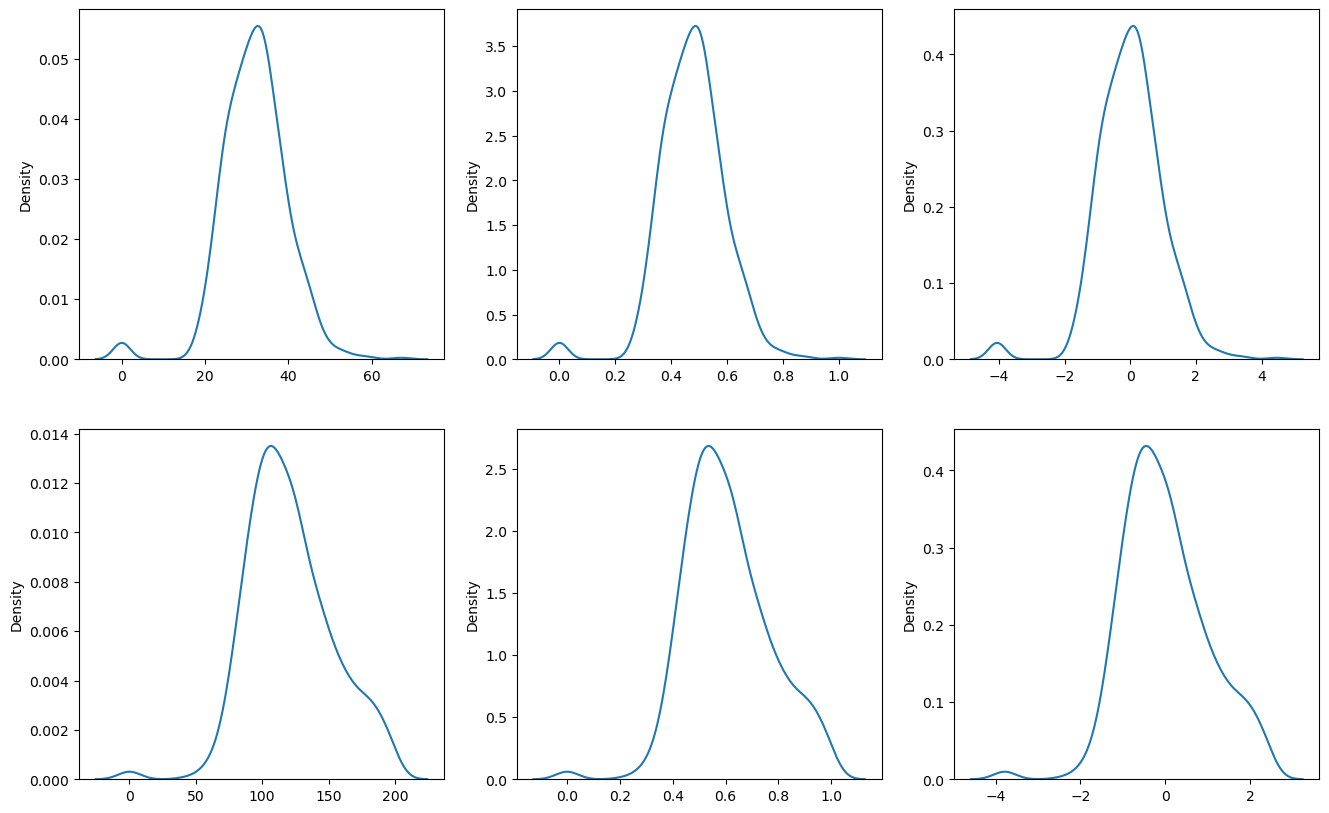

In [1394]:
#Visualize all
thinkplot.PrePlot(6,2,3)
sns.kdeplot(d1)
thinkplot.SubPlot(2)
sns.kdeplot(dumbNormalizer(d1))
thinkplot.SubPlot(3)
sns.kdeplot(dumbStandardizer(d1))
thinkplot.SubPlot(4)
sns.kdeplot(d2)
thinkplot.SubPlot(5)
sns.kdeplot(dumbNormalizer(d2))
thinkplot.SubPlot(6)
sns.kdeplot(dumbStandardizer(d2))
thinkplot.Config()

### Scaling Outcomes

For each of the scaling, the distribution is the same for the data after the transformation, but the ranges are different. We can also see visually the impact of outliers here - we'd normally want to address those in advance. In extreme cases, having a massive outlier can "squish" all the data at one end of the distribution, which will be bad in most cases. 

#### Scaling Caveat

One detail we've overlooked here is that the data should technically be scaler after the split of train/test data, and the scaler should only be trained on the training data (fit) and applied on the testing data (transform). This is to prevent any data leakage - the test data is supposed to be brand new, and if it is able to influence the scaling, then it has some impact on the training of the model. How much of an impact does this make? Probabaly not much for the vast majority of applications, but it is technically correct to keep 'em separated. 

We'll do the below example with it scaled 'properly'. 

<h3>Library Scaling Functions</h3>

Luckily, we don't really need to bust out our algebra to build any of these calculations by hand, we can use some built in functions in scikit learn to do it for us. These functions can also be built into a pipeline to process data (next semester), so we can build this transformation in without really seeing the resutlts. Like encoding last week, this takes data that is readable, and makes it not readable - we can package all of those steps in with our modelling, so legible data goes in - a trained model comes out. 

In scikit learn, the different functions for these methods are (examples below in code):
<ul>
<li>Normalization: MinMaxScaler
<li>Standardization: StandardScaler
</ul>

<h3>Example with Real Functions</h3>

Building scaling functions is pretty easy, in practice though we can use the sklearn ones, lets build that into the logistic regression for the diabetes prediction. 

In [1395]:
#Make arrays from data
dfY = df["Outcome"]
dfX = df.drop(columns={"Outcome"}) #There isn't generally a need to standardize the Y values

x = np.array(dfX)
y = np.array(dfY).reshape(-1,1)
x.shape, y.shape

((768, 8), (768, 1))

In [1396]:
#Split Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.33)

In [1397]:
#Create scaler and choose method. 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Comment one out, use the other
#scaler = StandardScaler()
scaler = MinMaxScaler()

In [1398]:
#Standardize or normalize
#Use training data to fit the scaler, then apply that predefined scale to the test data
x2 = scaler.fit_transform(X_train2)
X_trans2 = scaler.transform(X_test2)

We have standardized and normalized data, do linear regression stuff...

I'm going to set it up so we can swap the x data in the first line of code below, mostly to save typing. We can run everything twice, once for each scaling technique. 

In [1399]:
#Train model
model2 = LogisticRegression().fit(x2,y_train2.ravel())

#Make predictions
preds2 = model2.predict(X_trans2)

F1: 0.6496815286624203
Acc: 0.7834645669291339


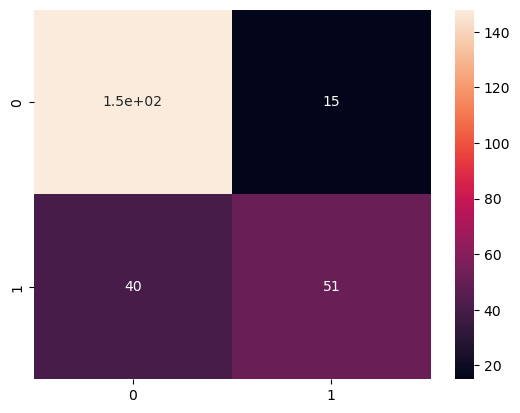

In [1400]:
#Generate 1/0 results and show results
labels2 = convert_prob_to_label(np.array(preds2))
conf_matrix2 = confusion_matrix(y_test2,labels2)
sns.heatmap(conf_matrix2, annot=True)

print("F1:",f1_score(y_test2, labels2))
print("Acc:",accuracy_score(y_test2, labels2))

Yay. We are super happy. 

IIRC, the accuracy without doing any scaling was similar (~76%), that's ok. This data didn't really have any massively differing ranges for the original data. We also didn't do any outlier filtering - what if we try that and repeat? We know from doing the dumb scaling, that there are a few outliers. 

There's a simple filter commented out up above, we'll go remove and repeat. It might make it better, it might not. This case only has a few outliers and they are not outrageous, so we shouldn't be surprised if the difference is relatively small. We can see that the errors are more balanced, so the F1 score does show improvement. 

#### With a Pipeline

We can use our pipeline to string the steps in our data prep together. In general, most of the sklearn functions that we may need can fit into these pipelines. Once the pipeline is made, it "is" our model - it will do whatever preparation steps we build into the list of actions. Here, we can use it to string together the scaling and the model; in other models we might add a step to deal with missing data (impute), perform encoding (like the one-hot get_dummies), or any number of steps. This allows us to build what is effectively a new model that contains both all of the data preparation and the modeling, all in one package. This is not required, but tends to make things more manageable. 

F1: 0.6496815286624203
Acc: 0.7834645669291339


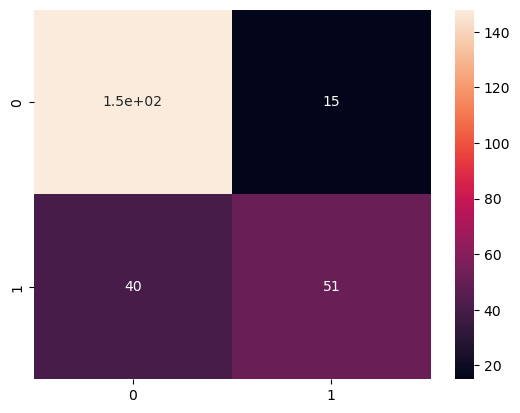

In [1401]:
# Make pipeline
m2 = make_pipeline( MinMaxScaler(),
                    LogisticRegression()
                    )

# Use pipeline like it is a model. 
m2.fit(X_train2, y_train2.ravel())
m2_pred = m2.predict(X_test2)

m2_label = convert_prob_to_label(np.array(m2_pred))
m2_matrix = confusion_matrix(y_test2,m2_label)
sns.heatmap(m2_matrix, annot=True)

print("F1:",f1_score(y_test2, m2_label))
print("Acc:",accuracy_score(y_test2, m2_label))

## Mini-Exercise

Try to remove outliers prior to scaling, and see if the accuracy improves.

In [1402]:
# Sans Outliers

<H1>Logistic Regression with Normalization Exercise</H1>

Logistic regression with normalization. 

Identify penguin sex. In doing so:
<ul>
<li>Explore the data. 
<li>Clean any erroneous data. 
<li>Create classification model. 

The sections below are just headers I had for an example solution, they aren't complete or comprehensive, and you can remove them if they are annoying. 

In [1403]:
df2 = sns.load_dataset("penguins")
df2.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Check data types. 

Check for missing. 

Numerical things look pretty OK. What about categorical?

Nothing looks too odd in the exploration (this is a toy dataset, so that's normal). We can do some modelling and predict sex...

I will sklearn, because I like it more. Statsmodels imight be useful in a bit, we could throw it in to get p values for the variables. 

Baseline is roughly 50/50, how'd we do? 

We're doing pretty well. What could be better? 

One suspicion I have would be that the species are somewhat different. Gentoo in particular seems to have different metrics, so maybe we'd predict it separately? I might need more data for that. 

Also, can we improve by removing confounding vars? Look at StatsModels to have an idea of variable relevance. 

I'll remove island and flipper length, try again, and see what's up...

Looks good!

Note: We have relatively little data, so the swings for accuracy between trials can be pretty pronounced. The first time I ran this there was a big improvement in accuracy after removing stuff, other runs had a smaller difference. More data would make it more stable, repeating the trials would also. You could build a loop to repeat trials, we'll do it the sklearn way early next semester. 

In [ ]:
# Code it. 

## Example - Logistic Regression from Scratch

We can take a look at the details of logistic regression by building it from scratch. This is not something we'd normally do, but it is a good way to see the details of how it works. The steps are relatively simple, the main thing that will seem odd is that we are doing calculations with matrices (arrays) instead of single values. This means that several of the lines, like the gradient and cost calculations, are performed on the entire dataset at once. This is called vectorization, and it is a common technique in ML for things that happen inside one of the algorithms.

This function below will do a logistic regression for us, in roughly the same way that the sklearn one does, though with much less polish. Note that most of the code below is for plotting, the actual logistic regression is only a few lines of code. The biggest leap in the code below is the line that does the dot product, as this one line of code - a matrix operation - will generate all the gradients for all the features at once. If you're not familiar with linear algebra, this likely seems odd, but we don't need a detailed understanding of the mechanics of the calculations to use it. In effect, that line calculates individual adjustment needs for each feature, and the next line scales those adjustments by the learning rate, or how big we want steps to be. The weights are changed by that amount, and we repeat the process - simple!! 

<b>Note:</b> try adding some print statements at a point in the code if something doesn't make sense. 

### The Plots

The plots generated are both the actual model - the decision boundary the separates the two groups. The data is displayed in two dimensions though, and we have 8 features, so our visualization is not perfect. The PLOT_FEAT variables near the top can be used to choose which features to plot. The model itself doesn't differ based on what we plot, even if our visualization looks totally different. We have to reduce the dimensions of our 8D data down to 2D so we can see it, which is a common technique we'll examine more later called dimensionality reduction. For now, we make a model that divides our data in 8-dimensional space, and we take a small sliver of that data to generate a visualization.

The other plot shows the total cost, or amount of error, at that stage of training. As we go through iterations, the cost should decrease as our model becomes better fitted to the data. Note that this is <i>not</i> the plot of loss that we look at for one feature at a time to explain gradient descent, this is a plot of the total cost for the entire dataset. The individual feature plots are good for explaining, but we don't know ahead of time what that plot will look like, and it isn't always a nice convex bowl. In reality, the gradient descent process isn't looking for "the bottom of the bowl", it is looking for a place where the gradient is 0 (indicating a flat spot) and a point where further moves can't lower that cost. These plots of feature vs cost exist, but we don't know the shape going in, they are "discovered" by the algorithm.

![Non-Convex](images/non_convex.png "Non-Convex")

In [1425]:
import matplotlib.pyplot as plt
from IPython import display
#!pip install ipywidgets
from ipywidgets import interact

PLOT_FEAT_1 = 0
PLOT_FEAT_2 = 1

# Sigmoid function
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

# Logistic regression function
def logistic_regression(X, y, alpha=.01, num_iter=1000, plotEvery=50):
    # The initializations could be set to anything, here we use zeros. 
    # Try swapping the ones line instead, that will give you a different starting point, and the speed to 
    # convergence, or find an answer, will be different.
    theta = np.zeros(X.shape[1]) # Initialize weights to zeros, this could be anything!
    #theta = np.ones(X.shape[1]) # Initialize weights to ones, this could be anything!
    costs = []
    thetas = []  # Store thetas at each iteration
    
    # Note the code looks somewhat weird here because the operations are on arrays, not scalars
    # This is called vectorization and is a way to speed up the code
    # The alternative is to use a for loop and do the operations on each element of the array
    for i in range(num_iter):
        z = np.dot(X, theta) # Linear Regression step (calculates logits - log of the odds)
        h = sigmoid(z) # Run that result through the sigmoid function
        gradient = np.dot(X.T, (h - y)) / y.size # Calculate gradient - these are the slopes of teh cost function for each variable
        theta -= alpha * gradient  # Calculate the adjustment to each weight by multiplying the gradient by the learning rate
        thetas.append(theta)

        # Calculate cost
        epsilon = 1e-5  # small constant
        cost = (-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon)).mean() # Binary cross entropy
        costs.append(cost)

        if i % plotEvery == 0:
            print(f'Cost and accuracy at iteration {i}: {round(cost,2)} {round(accuracy_score(y, np.round(h)) * 100,2)}%')
            print(f'\t\tGradients:', np.round(gradient, 2))
            print(f'\t\tThetas (Adjustments):', np.round(theta,2))
            plot_iteration(i, thetas, costs, X, y)
    
    return thetas, costs

# Function to plot decision boundary and cost
def plot_iteration(i, thetas, costs, X_,y_):
    theta = thetas[i]
    
    # Plot decision boundary
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_[:, PLOT_FEAT_1], X_[:, PLOT_FEAT_2], c=y_)
    ax = plt.gca()
    xvals = np.array(ax.get_xlim()).reshape(-1, 1)
    
    #yvals = -(xvals * theta[1] + theta[0]) / theta[0].all()
    yvals = -(xvals * theta[1] + theta[0])
    plt.plot(xvals, yvals, color='r', label='Decision Boundary')
    plt.xlabel('Feature: ' + str(PLOT_FEAT_1))
    plt.ylabel('Feature: ' + str(PLOT_FEAT_2))
    plt.title('Decision boundary')
    plt.legend()

    # Plot cost
    plt.subplot(1, 2, 2)
    plt.plot(costs[:i+1], marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Total Cost OOver Time')

    plt.tight_layout()
    #plt.show()


### Training Model

Cost and accuracy at iteration 0: 0.69 65.1%
		Gradients: [-0.11 -0.22 -0.03 -0.04 -0.06 -0.14 -0.08 -0.11]
		Thetas (Adjustments): [0. 0. 0. 0. 0. 0. 0. 0.]
Cost and accuracy at iteration 50: 0.65 72.79%
		Gradients: [-0.08 -0.18 -0.01 -0.02 -0.04 -0.11 -0.07 -0.09]
		Thetas (Adjustments): [0.05 0.1  0.01 0.01 0.03 0.06 0.04 0.05]
Cost and accuracy at iteration 100: 0.62 72.66%
		Gradients: [-0.07 -0.16 -0.   -0.01 -0.03 -0.09 -0.05 -0.07]
		Thetas (Adjustments): [0.09 0.19 0.01 0.02 0.04 0.12 0.07 0.09]
Cost and accuracy at iteration 150: 0.6 72.79%
		Gradients: [-0.06 -0.13  0.01 -0.01 -0.02 -0.08 -0.04 -0.05]
		Thetas (Adjustments): [0.12 0.26 0.01 0.03 0.05 0.16 0.09 0.12]
Cost and accuracy at iteration 200: 0.59 72.79%
		Gradients: [-0.05 -0.12  0.01 -0.   -0.01 -0.07 -0.04 -0.04]
		Thetas (Adjustments): [0.14 0.32 0.01 0.03 0.06 0.19 0.11 0.14]
Cost and accuracy at iteration 250: 0.58 72.79%
		Gradients: [-0.04 -0.1   0.01  0.   -0.01 -0.06 -0.03 -0.03]
		Thetas (Adjustments): [

Cost and accuracy at iteration 550: 0.55 73.7%
		Gradients: [-0.02 -0.05  0.02  0.    0.01 -0.03 -0.02 -0.01]
		Thetas (Adjustments): [ 0.24  0.6  -0.05  0.02  0.06  0.35  0.2   0.21]
Cost and accuracy at iteration 600: 0.55 73.83%
		Gradients: [-0.01 -0.05  0.02  0.    0.01 -0.03 -0.01 -0.  ]
		Thetas (Adjustments): [ 0.25  0.63 -0.06  0.02  0.05  0.37  0.2   0.21]
Cost and accuracy at iteration 650: 0.55 73.57%
		Gradients: [-0.01 -0.05  0.02  0.    0.01 -0.03 -0.01 -0.  ]
		Thetas (Adjustments): [ 0.25  0.65 -0.07  0.01  0.05  0.38  0.21  0.21]
Cost and accuracy at iteration 700: 0.54 73.18%
		Gradients: [-0.01 -0.04  0.02  0.    0.01 -0.02 -0.01 -0.  ]
		Thetas (Adjustments): [ 0.26  0.67 -0.08  0.01  0.04  0.39  0.22  0.21]
Cost and accuracy at iteration 750: 0.54 73.05%
		Gradients: [-0.01 -0.04  0.02  0.    0.01 -0.02 -0.01 -0.  ]
		Thetas (Adjustments): [ 0.27  0.69 -0.08  0.01  0.04  0.4   0.22  0.21]
Cost and accuracy at iteration 800: 0.54 72.79%
		Gradients: [-0.01 -0.04  0

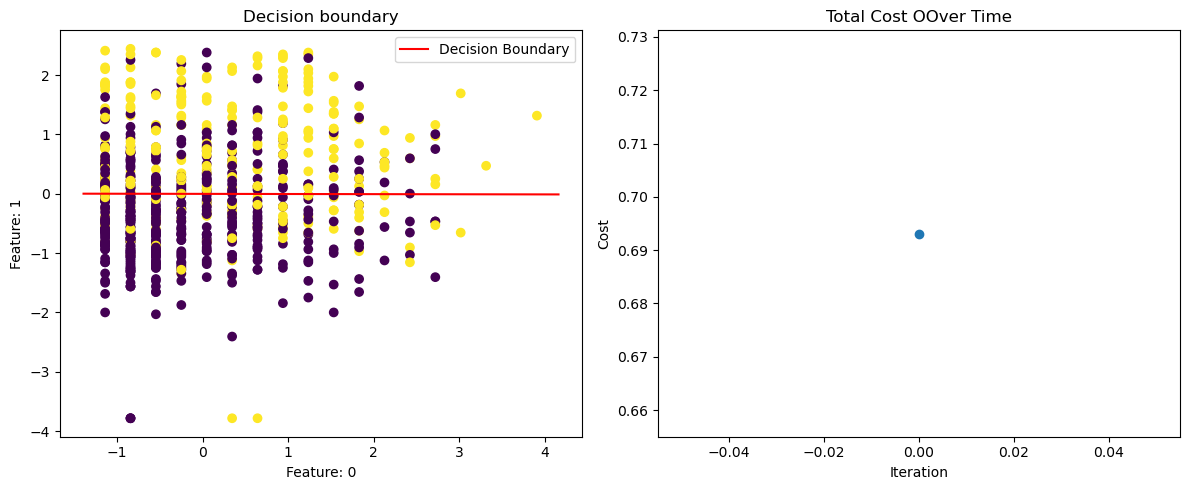

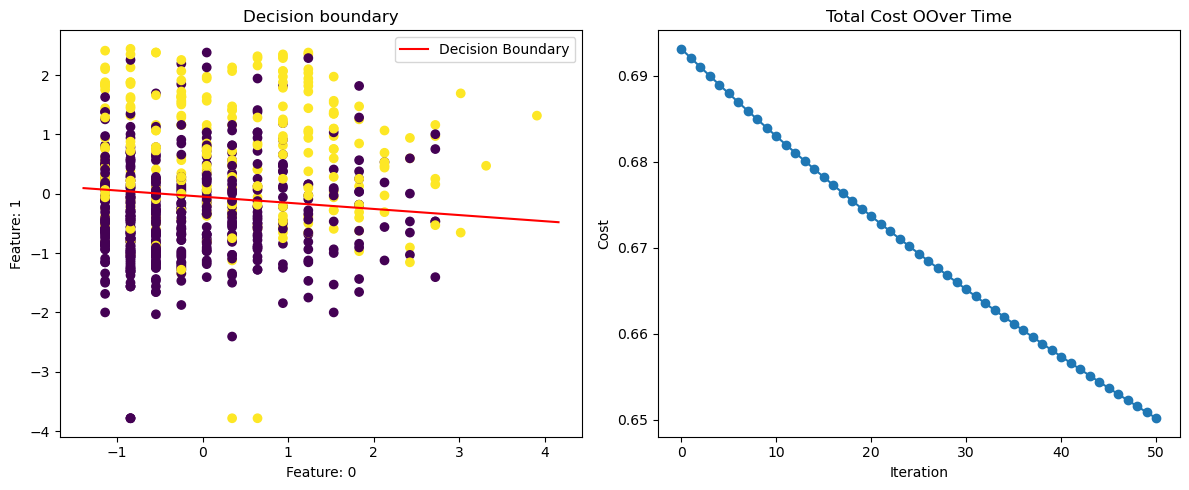

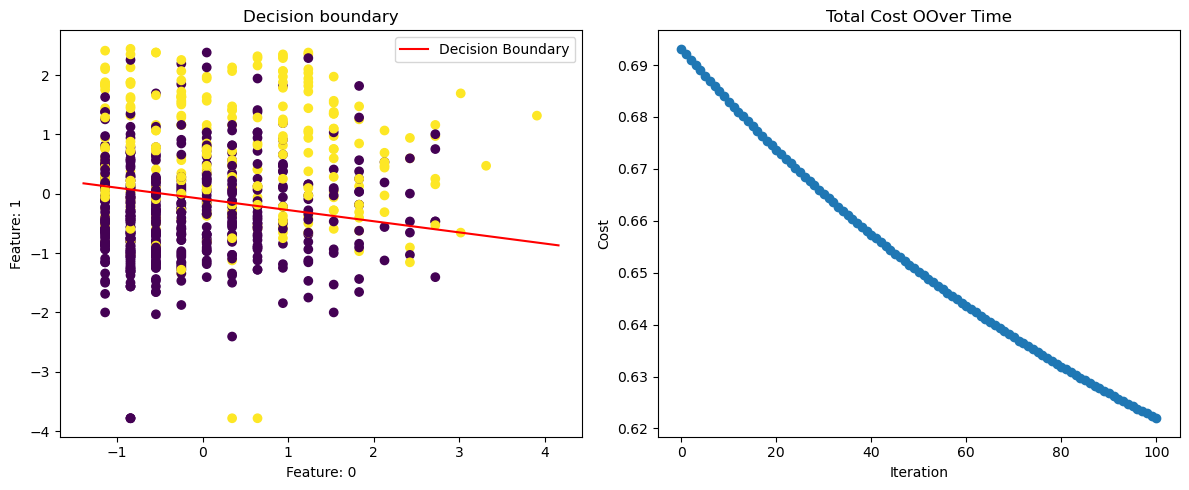

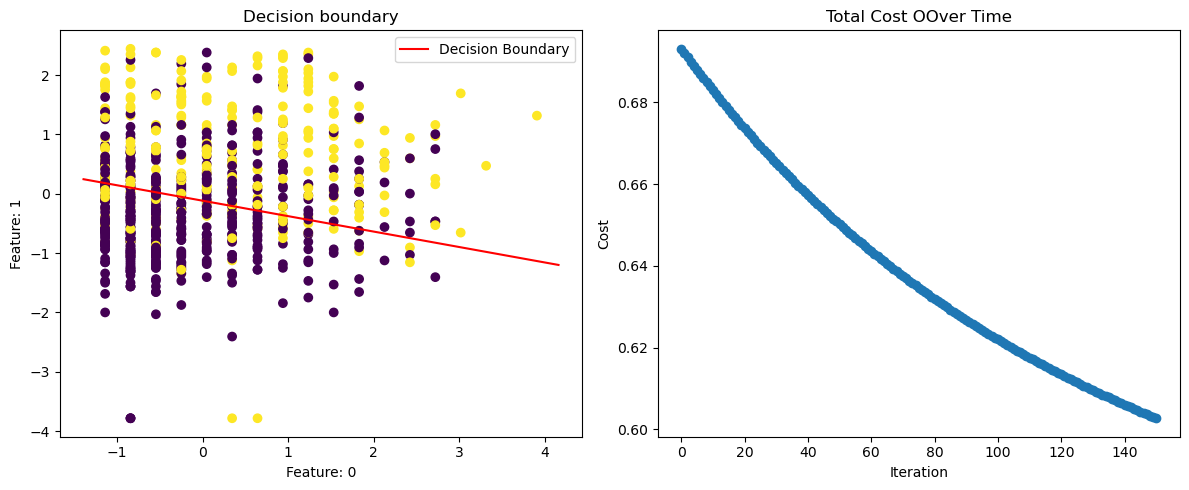

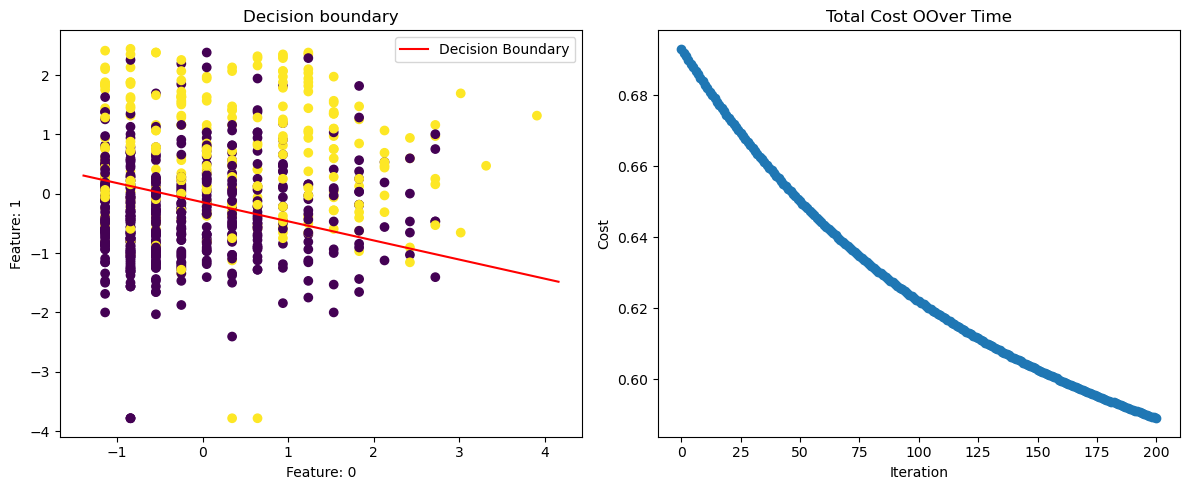

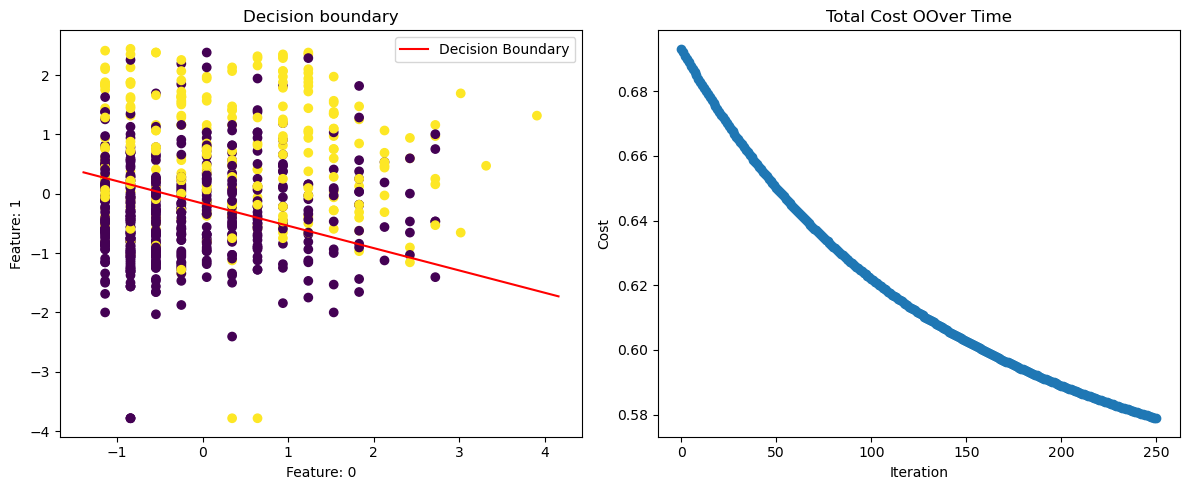

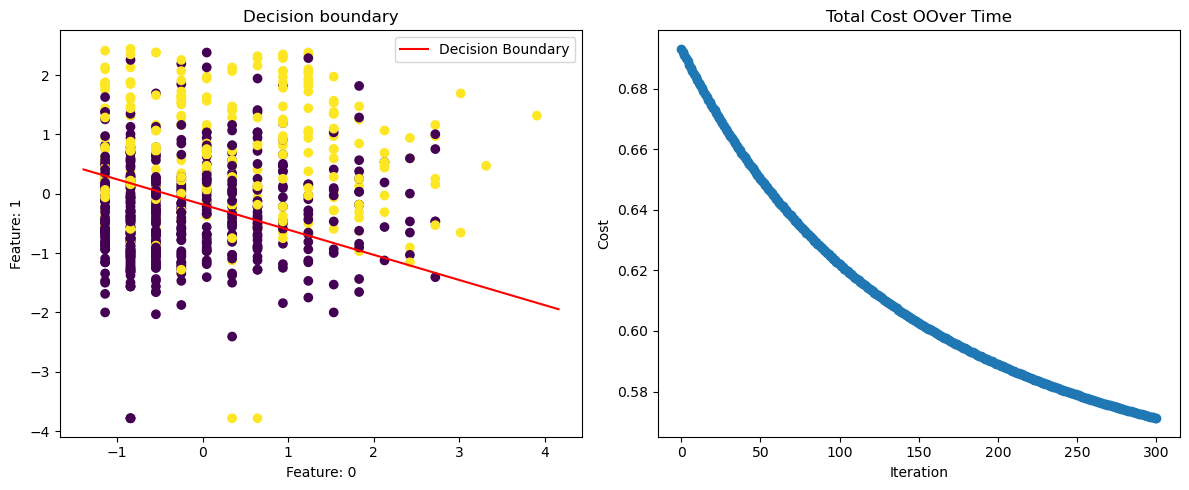

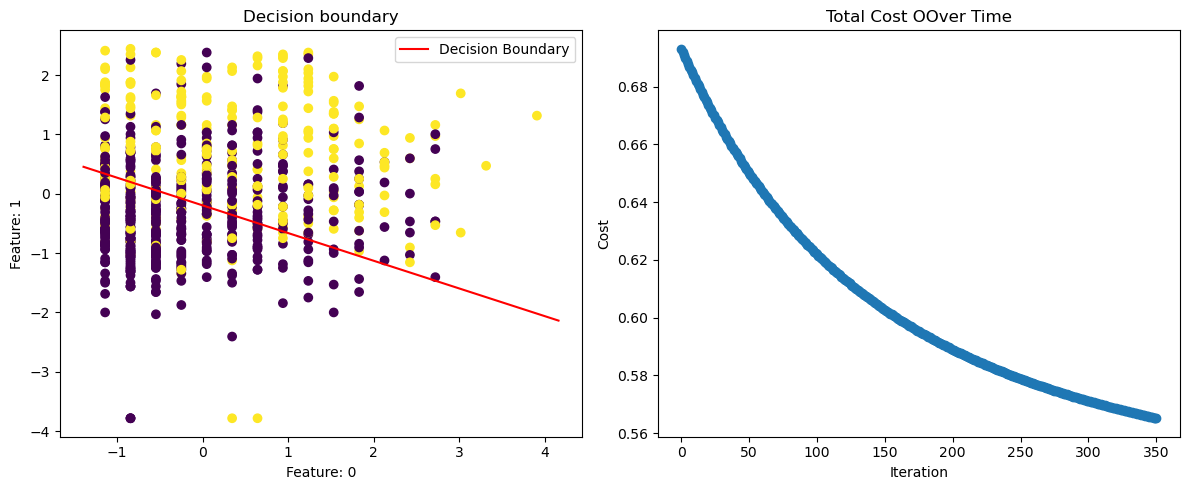

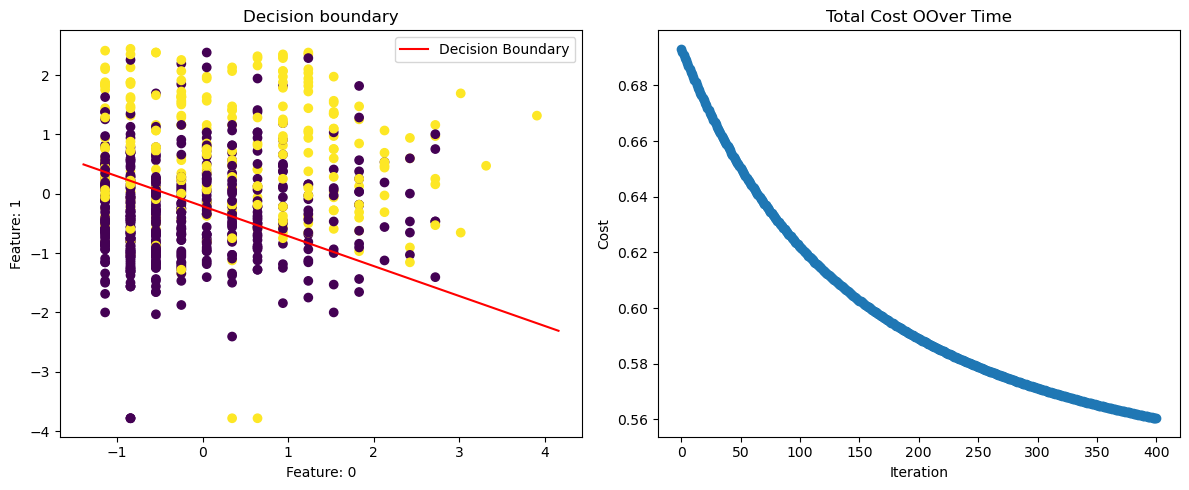

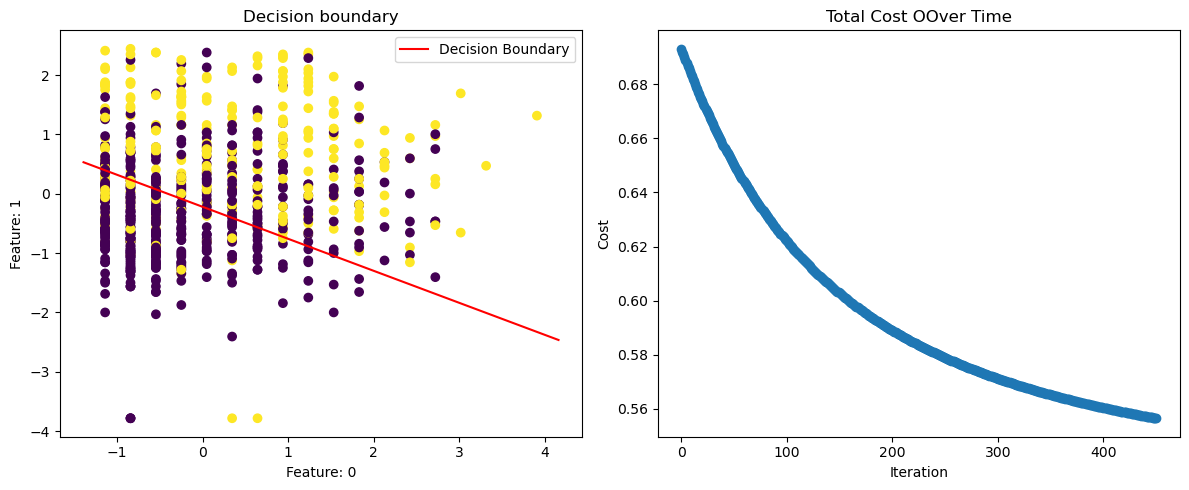

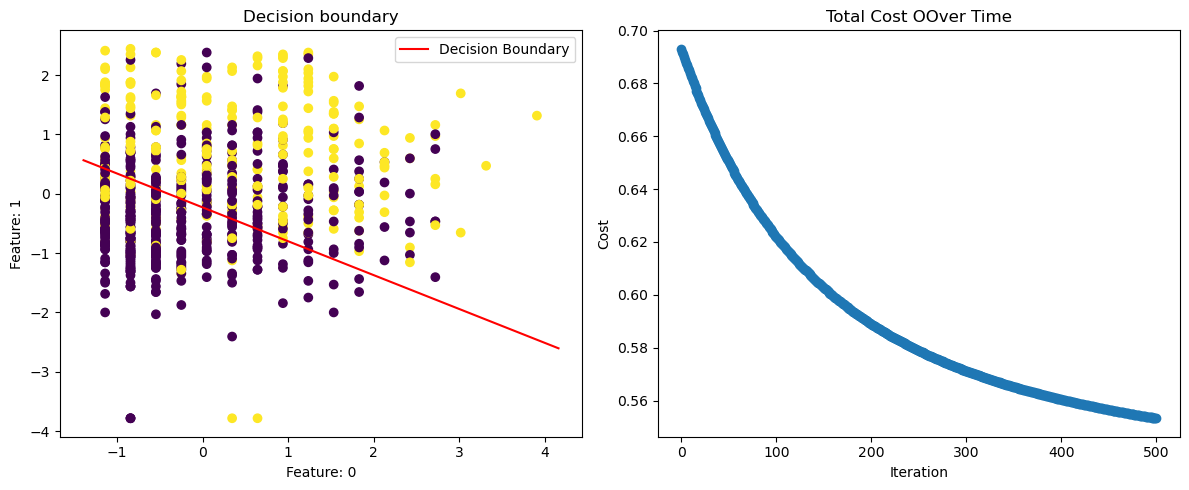

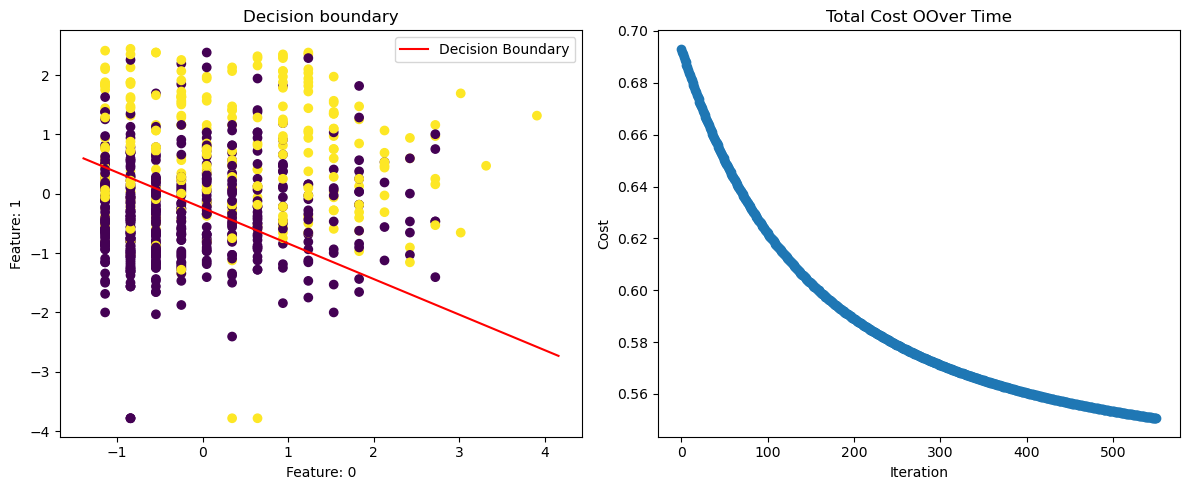

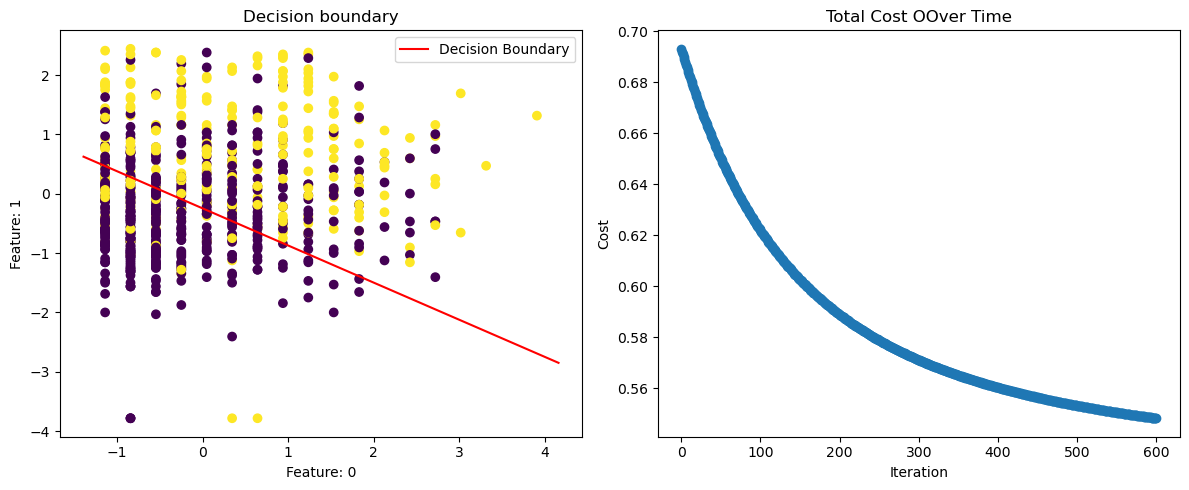

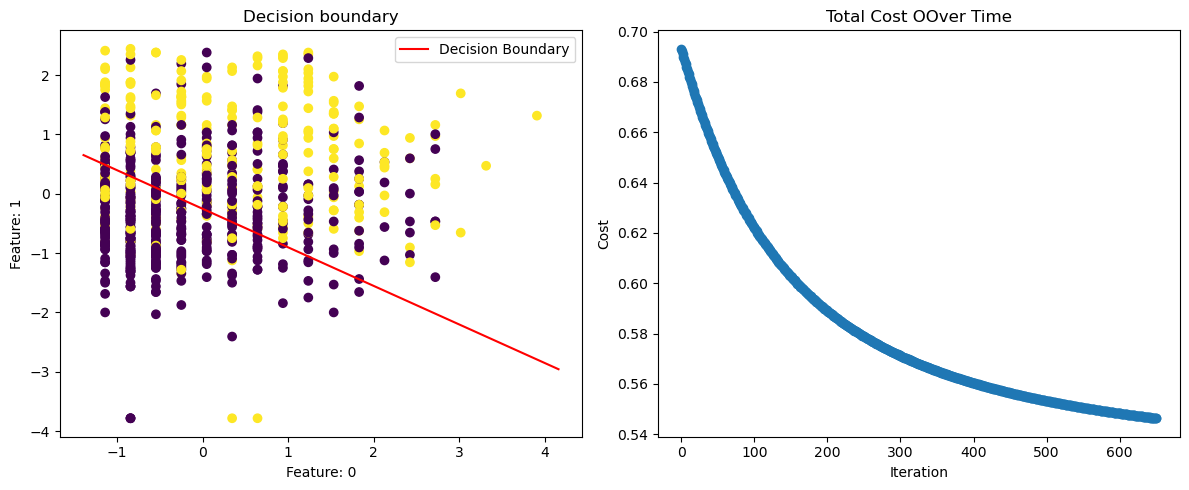

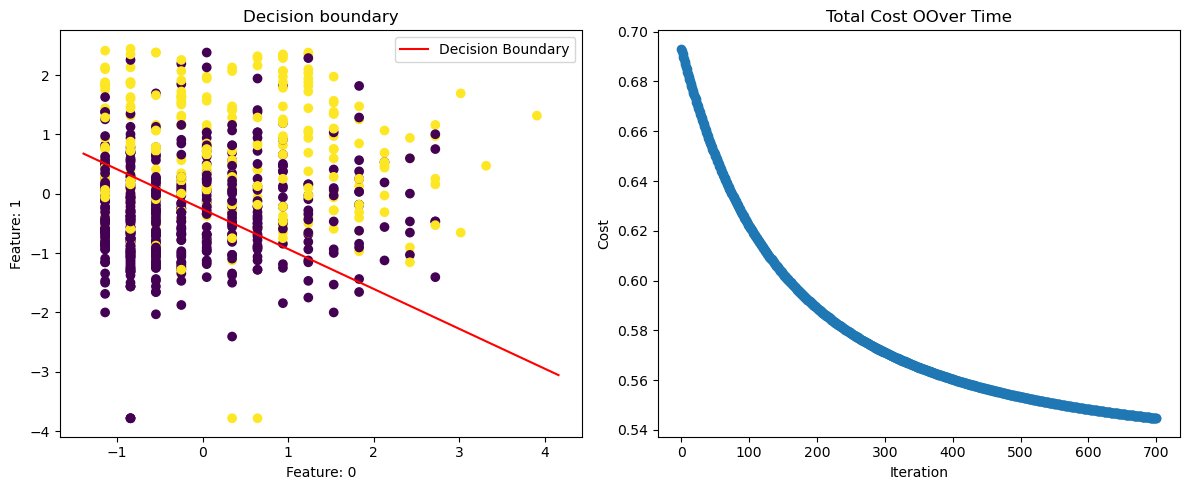

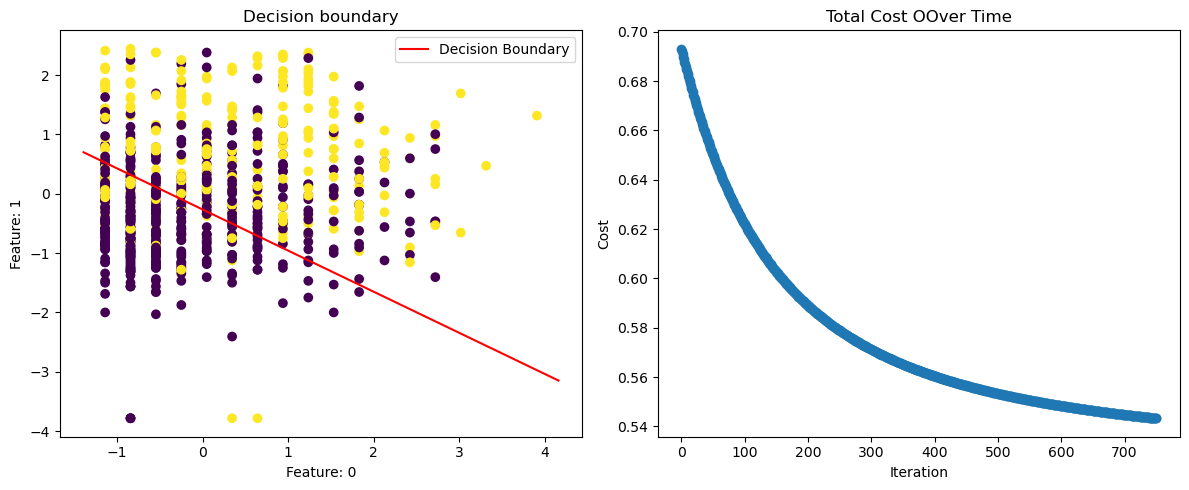

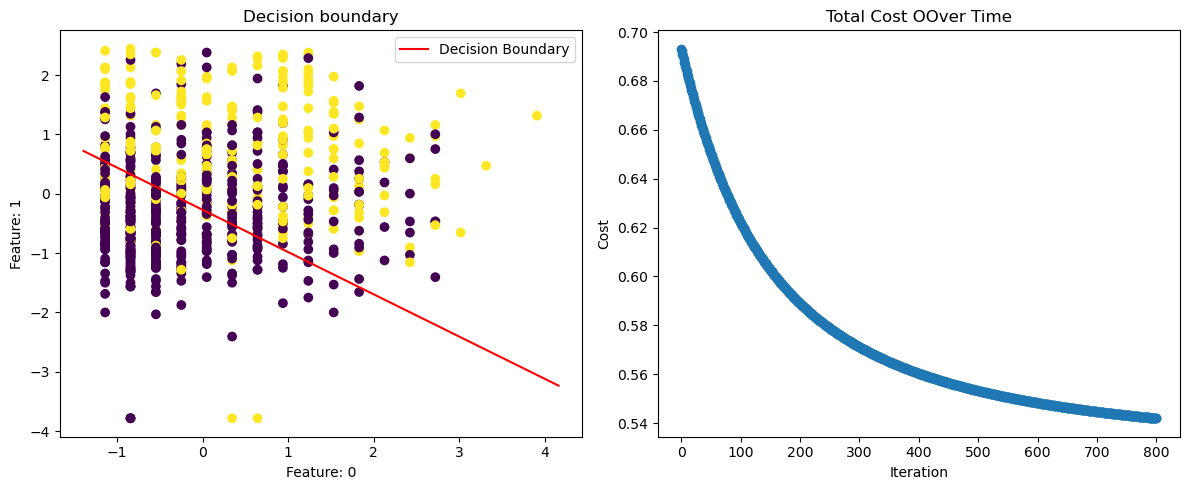

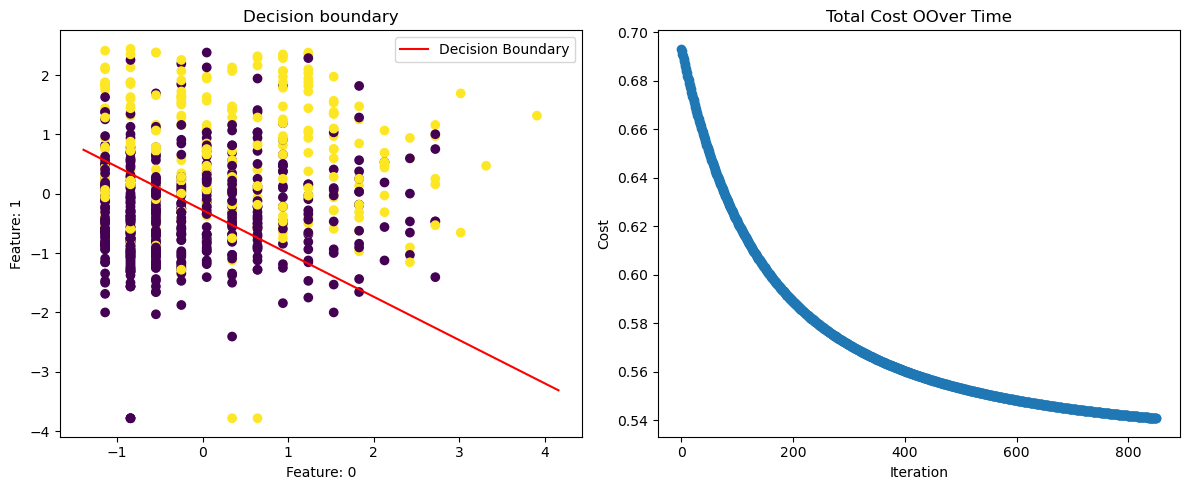

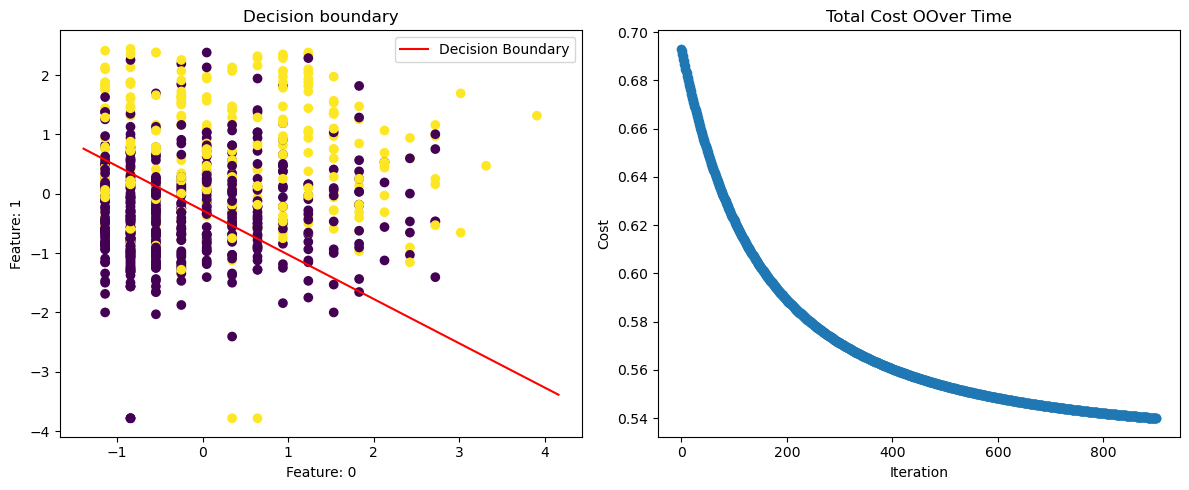

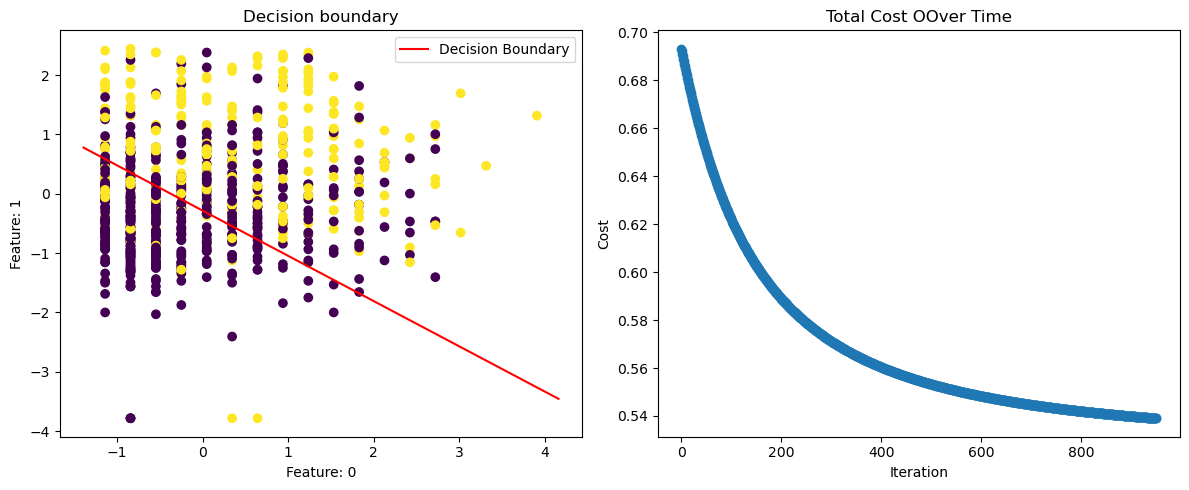

In [1426]:
df_dia = pd.read_csv("data/diabetes.csv")
df_dia.head()

# Example usage:
X = np.array(df_dia.drop(columns={"Outcome"}))
y = np.array(df_dia["Outcome"])


scaler = StandardScaler()
X = scaler.fit_transform(X)

thetas, costs = logistic_regression(X, y)
plt.show()